In [36]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.models import model_from_json

In [145]:
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
# To fetch financial data
import yfinance as yf

# For visualisation
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline

C:\Users\iftek\AppData\Local\Temp\ipykernel_10272\1106988778.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [23]:
# specify the number of lag hours
lag_hours = 10
n_features = 1
n_ahead = 5
n_obs = n_hours*n_features
dropnan=True
train_data_percent = 0.9

In [3]:
df = pd.read_csv('GBPUSD1440.csv',delimiter=',')
df.columns =['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Date,Time,Open,High,Low,Close,Volume
0,2016.11.23,00:00,1.24212,1.24671,1.23587,1.24252,61588
1,2016.11.24,00:00,1.24250,1.24928,1.24003,1.24497,53849
2,2016.11.25,00:00,1.24494,1.24800,1.24139,1.24738,61200
3,2016.11.27,00:00,1.24585,1.24799,1.24482,1.24782,1941
4,2016.11.28,00:00,1.24781,1.25296,1.23839,1.24064,63375


In [32]:
# load dataset
dataset = pd.read_csv('a.csv', header=0, usecols=['Open','High','Low','Close'])
# dataset['avg'] = dataset.mean(axis=1)

In [4]:
dataset = pd.read_csv('D1.csv', header=0, usecols=['Open','High','Low','Close'])

In [5]:
dataset

,Open,High,Low,Close
0,1.723811,1.727205,1.718390,1.718597
1,1.719010,1.732112,1.717298,1.730313
2,1.730493,1.731812,1.725209,1.728101
3,1.727414,1.728997,1.718302,1.720697
4,1.720608,1.733102,1.719809,1.733102
...,...,...,...,...
4900,1.145056,1.149491,1.122776,1.145134
4901,1.135589,1.138343,1.112038,1.135538
4902,1.116520,1.122372,1.109201,1.116208
4903,1.107444,1.111086,1.102354,1.107273


In [5]:
dataset = df

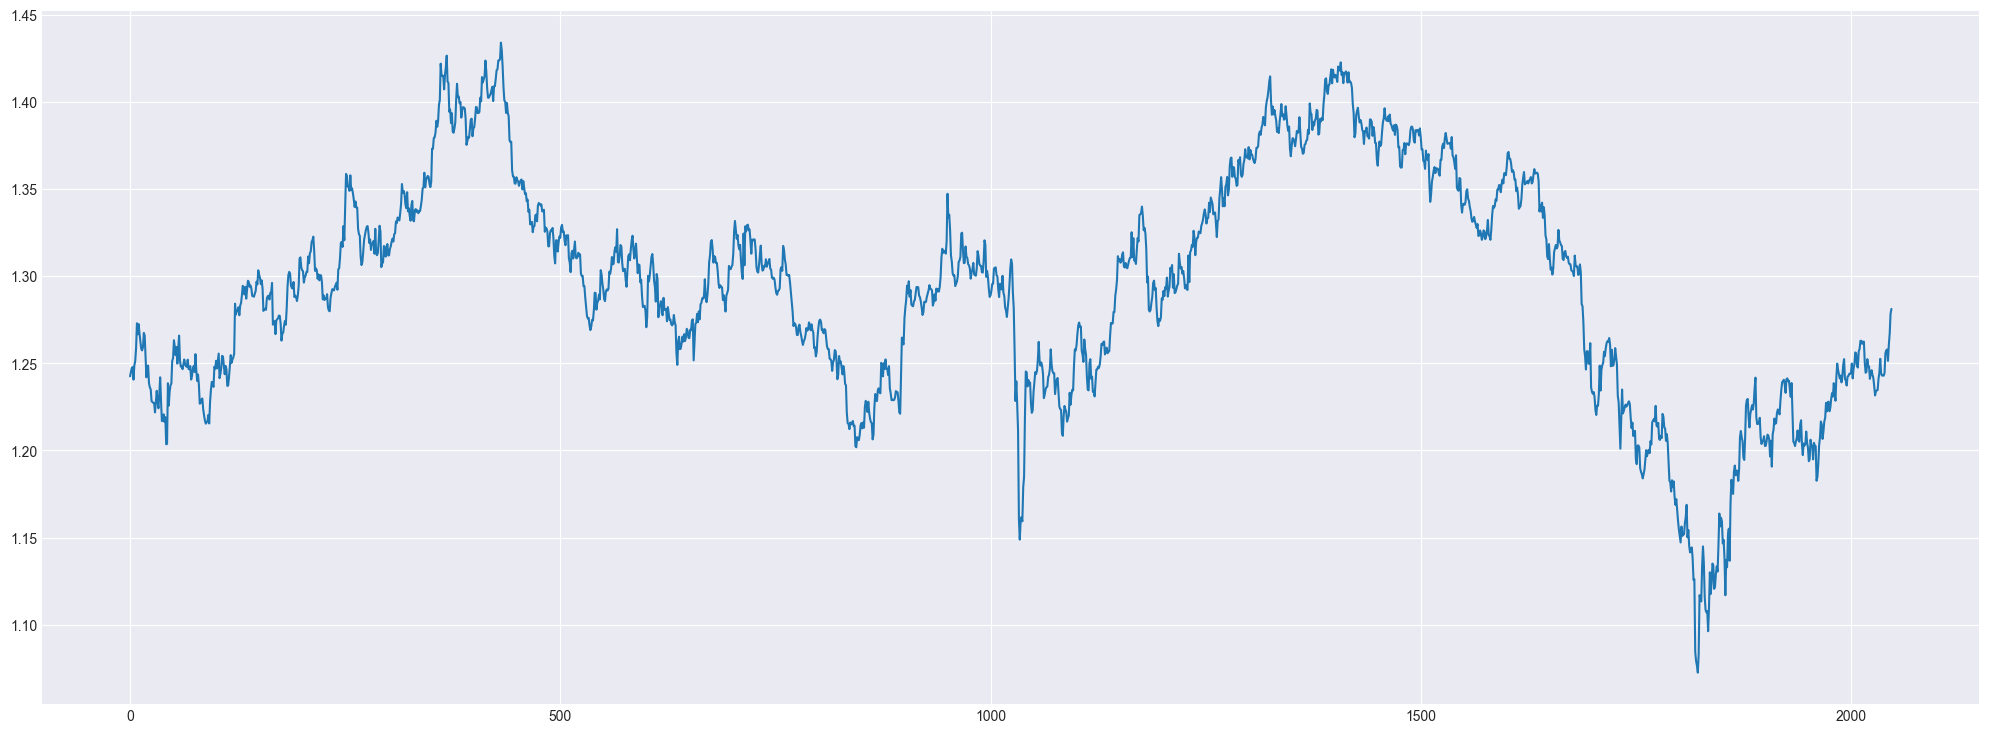

In [12]:
plt.figure(figsize=(25,9))
plt.plot(dataset.Close)
plt.show()

In [13]:
def process_feature(dataframe, col_name, laging_period, forecast_period):
    data = pd.DataFrame()

    for i in range(laging_period, 0, -1):
        data['(t-'+str(i)+')'] = dataframe[col_name].shift(i)

    for i in range(0, forecast_period):
        data['(t+'+str(i)+')'] = dataframe[col_name].shift(-i)

    if dropnan:
        data.dropna(inplace=True)
    return data


In [14]:
timestamp_frame = process_feature(dataset, 'Close', lag_hours, n_ahead)

timestamp_frame

,(t-10),(t-9),(t-8),(t-7),(t-6),(t-5),(t-4),(t-3),(t-2),(t-1),(t+0),(t+1),(t+2),(t+3),(t+4)
10,1.24252,1.24497,1.24738,1.24782,1.24064,1.24885,1.25123,1.25865,1.27298,1.26667,1.27250,1.26697,1.26258,1.25828,1.25742
11,1.24497,1.24738,1.24782,1.24064,1.24885,1.25123,1.25865,1.27298,1.26667,1.27250,1.26697,1.26258,1.25828,1.25742,1.25922
12,1.24738,1.24782,1.24064,1.24885,1.25123,1.25865,1.27298,1.26667,1.27250,1.26697,1.26258,1.25828,1.25742,1.25922,1.26747
13,1.24782,1.24064,1.24885,1.25123,1.25865,1.27298,1.26667,1.27250,1.26697,1.26258,1.25828,1.25742,1.25922,1.26747,1.26591
14,1.24064,1.24885,1.25123,1.25865,1.27298,1.26667,1.27250,1.26697,1.26258,1.25828,1.25742,1.25922,1.26747,1.26591,1.25338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2039,1.23383,1.23448,1.23470,1.24116,1.24447,1.25258,1.24427,1.24296,1.24317,1.24290,1.24441,1.25575,1.25749,1.25793,1.25140
2040,1.23448,1.23470,1.24116,1.24447,1.25258,1.24427,1.24296,1.24317,1.24290,1.24441,1.25575,1.25749,1.25793,1.25140,1.26059
2041,1.23470,1.24116,1.24447,1.25258,1.24427,1.24296,1.24317,1.24290,1.24441,1.25575,1.25749,1.25793,1.25140,1.26059,1.26702
2042,1.24116,1.24447,1.25258,1.24427,1.24296,1.24317,1.24290,1.24441,1.25575,1.25749,1.25793,1.25140,1.26059,1.26702,1.27841


In [15]:
#dataset.drop('dma', axis=1, inplace=True)
#print("column number")
#print(dataset.columns,len(dataset.columns),len(dataset.index))


dt = timestamp_frame.values
d = dt.astype(float)

print("Checkinf for NaN and Inf")
print( "np.nan=", np.where(np.isnan(d)))
print( "is.inf=", np.where(np.isinf(d)))

print("********************************************")
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(d)
d = imp.fit_transform(d)

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(d)
print("scaled values",scaled)



Checkinf for NaN and Inf
np.nan= (array([], dtype=int64), array([], dtype=int64))
is.inf= (array([], dtype=int64), array([], dtype=int64))
********************************************
scaled values [[0.47026758 0.47704696 0.48371565 ... 0.52577548 0.51387698 0.51149727]
 [0.47704696 0.48371565 0.48493317 ... 0.51387698 0.51149727 0.51647804]
 [0.48371565 0.48493317 0.46506544 ... 0.51149727 0.51647804 0.53930657]
 ...
 [0.44862891 0.46650433 0.47566341 ... 0.49483937 0.52026896 0.53806137]
 [0.46650433 0.47566341 0.49810454 ... 0.52026896 0.53806137 0.56957857]
 [0.47566341 0.49810454 0.47510999 ... 0.53806137 0.56957857 0.57732643]]


In [16]:
reframed = pd.DataFrame(scaled)
reframed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.470268,0.477047,0.483716,0.484933,0.465065,0.487783,0.494369,0.514901,0.554553,0.537093,0.553225,0.537923,0.525775,0.513877,0.511497
1,0.477047,0.483716,0.484933,0.465065,0.487783,0.494369,0.514901,0.554553,0.537093,0.553225,0.537923,0.525775,0.513877,0.511497,0.516478
2,0.483716,0.484933,0.465065,0.487783,0.494369,0.514901,0.554553,0.537093,0.553225,0.537923,0.525775,0.513877,0.511497,0.516478,0.539307
3,0.484933,0.465065,0.487783,0.494369,0.514901,0.554553,0.537093,0.553225,0.537923,0.525775,0.513877,0.511497,0.516478,0.539307,0.534990
4,0.465065,0.487783,0.494369,0.514901,0.554553,0.537093,0.553225,0.537923,0.525775,0.513877,0.511497,0.516478,0.539307,0.534990,0.500318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2029,0.446222,0.448020,0.448629,0.466504,0.475663,0.498105,0.475110,0.471485,0.472066,0.471319,0.475497,0.506876,0.511691,0.512908,0.494839
2030,0.448020,0.448629,0.466504,0.475663,0.498105,0.475110,0.471485,0.472066,0.471319,0.475497,0.506876,0.511691,0.512908,0.494839,0.520269
2031,0.448629,0.466504,0.475663,0.498105,0.475110,0.471485,0.472066,0.471319,0.475497,0.506876,0.511691,0.512908,0.494839,0.520269,0.538061
2032,0.466504,0.475663,0.498105,0.475110,0.471485,0.472066,0.471319,0.475497,0.506876,0.511691,0.512908,0.494839,0.520269,0.538061,0.569579


#### split into train and test sets

In [24]:
values = reframed.values
train_size = int(len(values) * train_data_percent)
# test_size = len(values) - train_size
train, test = values[0:train_size,:], values[train_size:-1,:]
print(train.shape, '\n', test.shape)

(1830, 15) 
 (203, 15)


#### split into input and outputs

In [33]:
n_obs = lag_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, train_y.shape, '\n', test_X.shape, len(test_X), test_y.shape, )


(1830, 10) (1830,) 
 (203, 10) 203 (203,)


#### reshape input to be 3D [samples, timesteps, features]

In [80]:
train_X = train_X.reshape((train_X.shape[0], lag_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], lag_hours, n_features))
print(train_X.shape, '\n', test_X.shape)

(1830, 10, 1) 
 (203, 10, 1)


In [41]:
from numpy import concatenate
from matplotlib import pyplot
from tqdm import trange  
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, RepeatVector, TimeDistributed
from tensorflow.keras.models import load_model

### Model 

In [39]:
train_X.shape[1]

10

In [147]:
model = Sequential()
# input_shape=(lag_hours, n_features)
model.add(LSTM(units=100,return_sequences=True,input_shape=(train_X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=20))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam',loss='mean_squared_error', metrics=['accuracy'], )

In [53]:
model = Sequential()

batchsize = 20
# design network
model.add(Bidirectional(LSTM(100,  activation='relu', input_shape=(lag_hours, n_features), return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(20, activation='relu'))
model.add(Dense(n_ahead))
model.compile(loss='mae', optimizer='adam')


Train on 10665 samples, validate on 1185 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
10665/10665 - 14s - loss: 0.0585 - val_loss: 0.0876
Epoch 2/20
10665/10665 - 12s - loss: 0.0238 - val_loss: 0.0776
Epoch 3/20
10665/10665 - 12s - loss: 0.0265 - val_loss: 0.0865
Epoch 4/20
10665/10665 - 12s - loss: 0.0315 - val_loss: 0.0822
Epoch 5/20
10665/10665 - 12s - loss: 0.0358 - val_loss: 0.0856
Epoch 6/20
10665/10665 - 12s - loss: 0.0376 - val_loss: 0.0915
Epoch 7/20
10665/10665 - 12s - loss: 0.0390 - val_loss: 0.0949
Epoch 8/20
10665/10665 - 12s - loss: 0.0424 - val_loss: 0.0954
Epoch 9/20
10665/10665 - 12s - loss: 0.0459 - val_loss: 0.0971
Epoch 10/20
10665/10665 - 12s - loss: 0.0483 - val_loss: 0.0995
Epoch 11/20
10665/10665 - 12s - loss: 0.0491 - val_loss: 0.1027
Epoch 12/20
10665/10665 - 12s - loss: 0.0492 - val_loss: 0.1051
Epoch 13/20
10665/10665 - 12s - loss: 0.0485 - val_loss: 0.1089
Epoch 14/20
10665/10665 - 12s - lo

In [148]:
epoch = 100
batchsize = 50

In [149]:
# fit network
history = model.fit(train_X, train_y, epochs=epoch, 
                    batch_size=batchsize, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/100
37/37 - 6s - loss: 0.0861 - accuracy: 0.0011 - val_loss: 0.0281 - val_accuracy: 0.0000e+00 - 6s/epoch - 157ms/step
Epoch 2/100
37/37 - 0s - loss: 0.0169 - accuracy: 0.0011 - val_loss: 0.0030 - val_accuracy: 0.0000e+00 - 485ms/epoch - 13ms/step
Epoch 3/100
37/37 - 0s - loss: 0.0168 - accuracy: 0.0011 - val_loss: 0.0021 - val_accuracy: 0.0000e+00 - 486ms/epoch - 13ms/step
Epoch 4/100
37/37 - 0s - loss: 0.0152 - accuracy: 0.0011 - val_loss: 0.0027 - val_accuracy: 0.0000e+00 - 492ms/epoch - 13ms/step
Epoch 5/100
37/37 - 0s - loss: 0.0144 - accuracy: 0.0011 - val_loss: 0.0040 - val_accuracy: 0.0000e+00 - 493ms/epoch - 13ms/step
Epoch 6/100
37/37 - 0s - loss: 0.0176 - accuracy: 0.0011 - val_loss: 0.0021 - val_accuracy: 0.0000e+00 - 484ms/epoch - 13ms/step
Epoch 7/100
37/37 - 0s - loss: 0.0135 - accuracy: 0.0011 - val_loss: 0.0026 - val_accuracy: 0.0000e+00 - 497ms/epoch - 13ms/step
Epoch 8/100
37/37 - 1s - loss: 0.0121 - accuracy: 0.0011 - val_loss: 0.0036 - val_accuracy: 0.0000e

Epoch 65/100
37/37 - 1s - loss: 0.0051 - accuracy: 0.0011 - val_loss: 0.0024 - val_accuracy: 0.0000e+00 - 548ms/epoch - 15ms/step
Epoch 66/100
37/37 - 1s - loss: 0.0054 - accuracy: 0.0011 - val_loss: 0.0024 - val_accuracy: 0.0000e+00 - 535ms/epoch - 14ms/step
Epoch 67/100
37/37 - 1s - loss: 0.0055 - accuracy: 0.0011 - val_loss: 0.0024 - val_accuracy: 0.0000e+00 - 548ms/epoch - 15ms/step
Epoch 68/100
37/37 - 1s - loss: 0.0052 - accuracy: 0.0011 - val_loss: 0.0023 - val_accuracy: 0.0000e+00 - 543ms/epoch - 15ms/step
Epoch 69/100
37/37 - 1s - loss: 0.0054 - accuracy: 0.0011 - val_loss: 0.0022 - val_accuracy: 0.0000e+00 - 521ms/epoch - 14ms/step
Epoch 70/100
37/37 - 1s - loss: 0.0056 - accuracy: 0.0011 - val_loss: 0.0026 - val_accuracy: 0.0000e+00 - 532ms/epoch - 14ms/step
Epoch 71/100
37/37 - 1s - loss: 0.0055 - accuracy: 0.0011 - val_loss: 0.0023 - val_accuracy: 0.0000e+00 - 535ms/epoch - 14ms/step
Epoch 72/100
37/37 - 1s - loss: 0.0056 - accuracy: 0.0011 - val_loss: 0.0024 - val_accurac

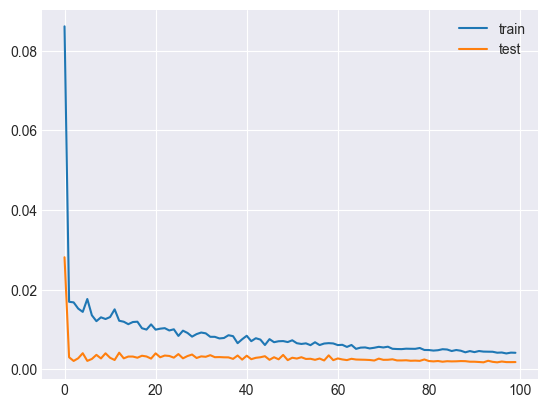

In [150]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [47]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

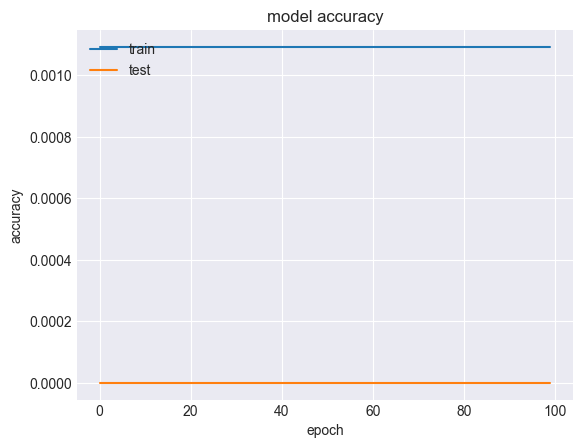

In [151]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [49]:
# evaluate the model
scores = model.evaluate(train_X, train_y, verbose=0)
print(model.metrics_names, scores*100)

['loss', 'accuracy'] [0.0035475941840559244, 0.0010928962146863341, 0.0035475941840559244, 0.0010928962146863341, 0.0035475941840559244, 0.0010928962146863341, 0.0035475941840559244, 0.0010928962146863341, 0.0035475941840559244, 0.0010928962146863341, 0.0035475941840559244, 0.0010928962146863341, 0.0035475941840559244, 0.0010928962146863341, 0.0035475941840559244, 0.0010928962146863341, 0.0035475941840559244, 0.0010928962146863341, 0.0035475941840559244, 0.0010928962146863341, 0.0035475941840559244, 0.0010928962146863341, 0.0035475941840559244, 0.0010928962146863341, 0.0035475941840559244, 0.0010928962146863341, 0.0035475941840559244, 0.0010928962146863341, 0.0035475941840559244, 0.0010928962146863341, 0.0035475941840559244, 0.0010928962146863341, 0.0035475941840559244, 0.0010928962146863341, 0.0035475941840559244, 0.0010928962146863341, 0.0035475941840559244, 0.0010928962146863341, 0.0035475941840559244, 0.0010928962146863341, 0.0035475941840559244, 0.0010928962146863341, 0.0035475941

In [52]:
scores

[0.0035475941840559244, 0.0010928962146863341]

In [152]:
# make a prediction
yhat = model.predict(test_X)
print(test_X.shape, '\t', yhat.shape)

7/7 [==============================] - 1s 6ms/step
(203, 10, 1) 	 (203, 1)


In [153]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [154]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

# Load the model weights into the architecture
loaded_model = model_from_json(loaded_model_json)

# Load the weights into the loaded model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")


Loaded model from disk


In [155]:
# make a prediction
yhat = loaded_model.predict(test_X)

7/7 [==============================] - 1s 6ms/step


In [62]:
yhat.shape

(203, 1)

In [71]:
def plot(testdata_X, n_hours, n_features, prediction):
    testdata_X = testdata_X.reshape((testdata_X.shape[0], n_hours*n_features))
    forecast_y = np.concatenate([testdata_X[:, -1], prediction[-1,:]])
    plt.figure(figsize=(25,9))
    plt.plot(forecast_y, color='red')
    plt.plot(testdata_X[:, -1], color='blue')

In [156]:
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.042


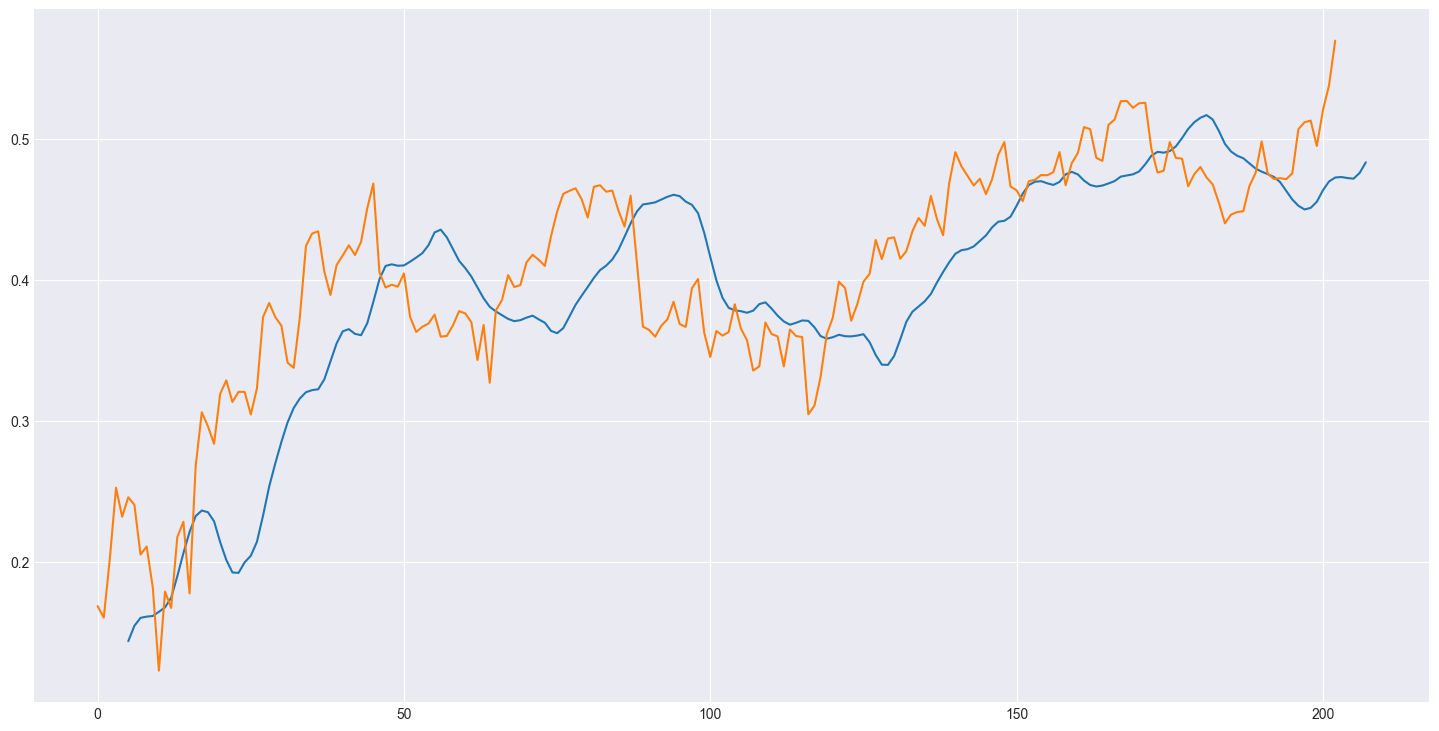

In [157]:
filler = np.empty_like(np.zeros((n_ahead, 1)))
filler[:, :] = np.nan

plt.figure(figsize=(18,9))
plt.plot(np.concatenate((filler, yhat)))
plt.plot(test_y)

In [158]:
input_size = 20
results = []
for i in range(0, test_X.shape[0], input_size):
    predict = loaded_model.predict(test_X[i:i+input_size,:,:])
    results.append(predict)

1/1 [==============================] - 0s 30ms/step


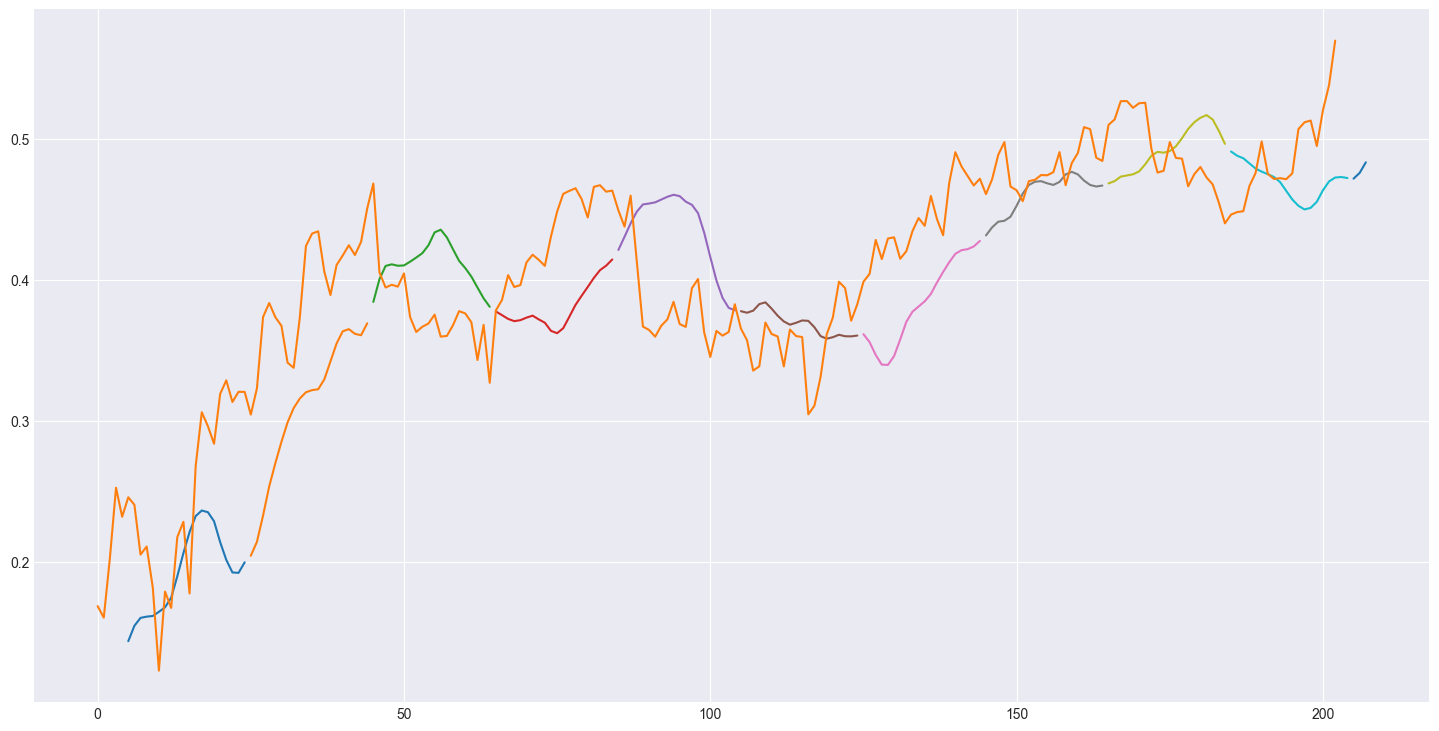

In [159]:
plt.figure(figsize=(18,9))
flag = 0
# temp = np.zeros((0,1))
for i in results:
    if flag==0:
        temp = np.concatenate((filler, i))
        flag=flag+1    
        plt.plot(temp)
    else:
        filler_int = np.empty_like(temp)
        filler_int[:, :] = np.nan
        temp = np.concatenate((filler_int, i))
        plt.plot(temp)
    
plt.plot(test_y)
plt.show()